# Fancy kerstkaartjes
Fancy kerstkaartjes o.b.v. OSM data rond de woonplaats.<br>
Dries Verdoodt & Inne Vanderkelen<br>
13/11/2020<br>

Inspiration by: https://ggplot2tutor.com/streetmaps/streetmaps/

In [2]:
import ogr
import shapely
from shapely.geometry import *
from pyproj import Proj, Transformer, CRS
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Set variables and functions

In [3]:
driver = ogr.GetDriverByName("OSM")
inProj = CRS('EPSG:4326')
outProj = CRS('epsg:31370')
transformer = Transformer.from_crs("epsg:4326", "epsg:31370")

In [4]:
# Define a dictionary with locations and boudning boxes in LB72 coordinates
# Define the zoom factor as a factor of 1. Smaller than 1 means zoom in. Higher than 1 means zoom out.

locaties = {
    'Zottegem':  {'center': (110570, 172909), 'zoom_factor': 1.85, 'orientation':'landscape'},
    'Opwijk':    {'center': (50.9621, 4.1785), 'zoom_factor': 1.95, 'orientation':'portrait'},
    'Sint-Amandsberg':    {'center': (106261,194311), 'zoom_factor': 0.85, 'orientation':'landscape'},
    
    'Baardegem': {'center': (134047, 182750), 'zoom_factor': 4, 'orientation':'landscape'},   
    'Lebbeek':   {'center': (133850, 187778), 'zoom_factor': 4, 'orientation':'landscape'},  
    'Brussegem': {'center': (143632, 181259), 'zoom_factor': 4, 'orientation':'landscape'},  
    'Gent':      {'center': (104964, 193908), 'zoom_factor': 10, 'orientation':'landscape'}
}
print(locaties)

{'Zottegem': {'center': (110570, 172909), 'zoom_factor': 1.85, 'orientation': 'landscape'}, 'Opwijk': {'center': (50.9621, 4.1785), 'zoom_factor': 1.95, 'orientation': 'portrait'}, 'Sint-Amandsberg': {'center': (106261, 194311), 'zoom_factor': 0.85, 'orientation': 'landscape'}, 'Baardegem': {'center': (134047, 182750), 'zoom_factor': 4, 'orientation': 'landscape'}, 'Lebbeek': {'center': (133850, 187778), 'zoom_factor': 4, 'orientation': 'landscape'}, 'Brussegem': {'center': (143632, 181259), 'zoom_factor': 4, 'orientation': 'landscape'}, 'Gent': {'center': (104964, 193908), 'zoom_factor': 10, 'orientation': 'landscape'}}


## Start loop

In [8]:
locatie = 'Opwijk'  ## Replace this by a loop when all the *.osm files are downloaded

#for locatie in locaties:
#    print(locatie)


# Set width and height
if locaties[locatie]['orientation'] == 'landscape':
    width, height = 1500, 1000
elif locaties[locatie]['orientation'] == 'portrait':
    width, height = 1000, 1500

# Get center coordinates of the place
x_wgs84 = locaties[locatie]['center'][0]
y_wgs84 = locaties[locatie]['center'][1]
x_lb72, y_lb72 = transformer.transform(x_wgs84,y_wgs84)


# Read [locatie].osm file
data = driver.Open("./data/{0}.osm".format(locatie))

layer_points = data.GetLayer('points')
layer_lines = data.GetLayer('lines')
layer_multilinestrings = data.GetLayer('multilinestrings')
layer_multipolygons = data.GetLayer('multipolygons')
layer_other_relations = data.GetLayer('other_relations')

line_features = [x for x in layer_lines]

# Convert to a gpd dataframe

street_list=[]
for feature in line_features: ## remove the [0] after test
    
    data=feature.ExportToJson(as_object=True)
    #print(data)
    
    coords=data['geometry']['coordinates']
    shapely_geo=LineString([coords[i] for i in range(len(coords))])

    osm_id=data['properties']['osm_id']
    name=data['properties']['name']
    highway=data['properties']['highway']
    waterway=data['properties']['waterway']
    
    other_tags=data['properties']['other_tags']
    if other_tags and 'railway' in other_tags:
        feat=[x for x in other_tags.split(',') if 'railway' in x][0]
        railway=feat[feat.rfind('>')+2:feat.rfind('"')]
    else:
        railway=None
       
    street_list.append([osm_id, name, highway, waterway, railway, shapely_geo])

gdf=gpd.GeoDataFrame(street_list,columns=['osm_id','name','highway','waterway','railway', 'geometry'],crs=inProj).to_crs(outProj)

# Prepare the geodataframes for each theme (roads, water, rail)
# Roads
gdf.highway.unique()
road_1 = gdf[gdf.highway.isin(['motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary', 'primary_link', 'secondary', 'secondary_link'])]
#road_1.plot(figsize=(15, 10), color='black').axis('off')

road_2 = gdf[gdf.highway.isin(['tertiary', 'tertiary_link', 'unclassified', 'residential'])]
#road_2.plot(figsize=(15, 10), color='black').axis('off')

road_3 = gdf[gdf.highway.isin(['living_street','unclassified','service','footway','road', 'track', 'path', 'pedestrian', 'cycleway', 'footway', 'steps', 'platform'])]
#road_3.plot(figsize=(15, 10), color='black').axis('off')

# Water
gdf.waterway.unique()
water = gdf[gdf.waterway.isin(['stream', 'river', 'ditch'])]
#water.plot(figsize=(15, 10), color='blue').axis('off')

# Railway
gdf.railway.unique()
rail = gdf[gdf.railway == 'rail']
#rail.plot(figsize=(15, 10), color='grey').axis('off')

# Plot the figure

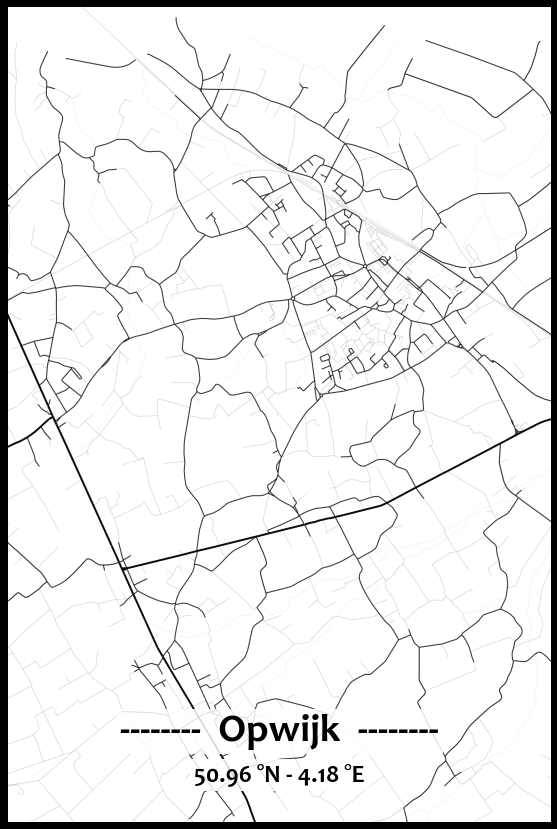

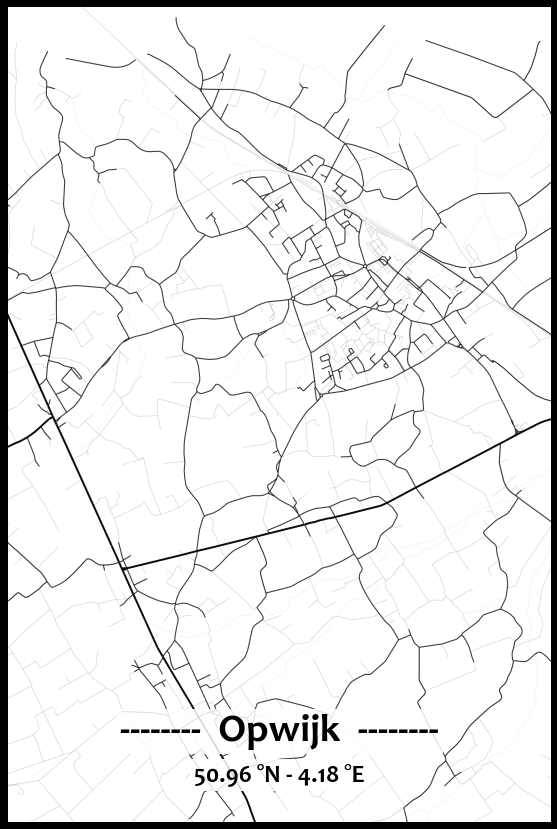

In [10]:
# Plot figure
fig, ax = plt.subplots(figsize=(width/100,height/100), edgecolor='k', linewidth=15, frameon=True)  ## Create one figure and one axes object

# Remove redundant Axes elements
# Remove x and y axis
ax.set_xticks([])
ax.set_yticks([])

# Remove the box around the Axes object
ax.set_frame_on(False)

# Plot layers on one figure
# plot waterways
water.plot(ax=ax, color=(0.44,0.84,0.98,0.25), linewidth=0.5, zorder=5)

# plot railways
rail.plot(ax=ax, color=(0.55,0.55,0.55,0.25), linewidth=0.5, zorder=4)

# Plot roads
road_1.plot(ax=ax, color=(0,0,0,0.95), linewidth=1.95, zorder=3)
road_2.plot(ax=ax, color=(0,0,0,0.75), linewidth=1.10, zorder=2)
road_3.plot(ax=ax, color=(0,0,0,0.15), linewidth=0.75, zorder=1)

# Zoom to a certain bbox extent
# Set the (new) boundaries of the Axes object (zoom)
zoom_factor = locaties[locatie]['zoom_factor']
x_min = x_lb72-(zoom_factor*width)
x_max = x_lb72+(zoom_factor*width)

y_min = y_lb72-(zoom_factor*height)
y_max = y_lb72+(zoom_factor*height)

x_pos_title = x_lb72
y_pos_title = y_min + (y_max-y_min)*0.10
x_pos_subtitle = x_lb72
y_pos_subtitle = y_min + (y_max-y_min)*0.05

# Set bounds
ax.set_xbound(x_min, x_max)
ax.set_ybound(y_min, y_max)

# Add a title on the bottom of the map
fontdict_title = {'family':'Candara','fontsize':40,'fontweight':'semibold','verticalalignment':'baseline','horizontalalignment':'center'}
fontdict_subtitle = {'family':'Candara','fontsize':25,'fontweight':'semibold','verticalalignment':'baseline','horizontalalignment':'center'}

#ax.set_xlabel('X-label')
# ax.set_title('--------  {0}  --------'.format(locatie), fontdict=fontdict, backgroundcolor=(1,1,1,0.85), y=0.05)
ax.text(x_pos_title, y_pos_title, '--------  {0}  --------'.format(locatie),fontdict=fontdict_title, backgroundcolor=(1,1,1,0.85))
ax.text(x_pos_subtitle, y_pos_subtitle, '{0} °N - {1} °E'.format(round(x_wgs84,2),round(y_wgs84,2)),fontdict=fontdict_subtitle, backgroundcolor=(1,1,1,0.85))

## loc='center', pad=-(height)
#fig.tight_layout()
fig

In [11]:
fig.savefig('./output/{0}.png'.format(locatie))